# 1. Import libraries

In [73]:
import time
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, 

# data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# plot visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# PCA
from sklearn.decomposition import PCA

# 2. Breast Cancer Wisconsin (diagnostic) dataset

__Attribute Information:__

__1)__ Clump_Thickness

__2)__ Cell_Size_Uniformity	

__3)__ Cell_Shape_Uniformity

__4)__ Marginal Adhesion

__5)__ Single Epi Cell Size

__6)__ Bare Nuclei

__7)__ Bland Chromatin

__8)__ Normal Nucleoli

__9)__ Mitoses

__10)__ Class {Benign ; Malign}

## 2.1. Read csv file

In [74]:
dataset = pd.read_csv("cancer.csv")
display(dataset.columns)
display(dataset.info())
dataset['Class']=dataset['Class'].map({' malignant':1,' benign':0})
dataset.head()

Index(['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity',
       'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei',
       'Bland_Chromatin', 'Normal_Nucleoli', 'Bare_Nuclei.1', 'Class'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump_Thickness          699 non-null int64
Cell_Size_Uniformity     699 non-null int64
Cell_Shape_Uniformity    699 non-null int64
Marginal_Adhesion        699 non-null int64
Single_Epi_Cell_Size     699 non-null int64
Bare_Nuclei              699 non-null float64
Bland_Chromatin          699 non-null int64
Normal_Nucleoli          699 non-null int64
Bare_Nuclei.1            699 non-null int64
Class                    699 non-null object
dtypes: float64(1), int64(8), object(1)
memory usage: 54.7+ KB


None

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1,Class
0,7,4,5,10,2,10.00,3,8,2,1
1,5,3,4,1,4,1.00,3,1,1,0
2,9,9,10,3,6,10.00,7,10,6,1
3,1,1,2,1,3,1.37,1,1,1,0
4,5,7,9,8,6,10.00,8,10,1,1


__Observations:__

By observing the information about the dataset we can see that the __class__ column corresponds to the true label of the samples so we will label _malign_ diagnosis as 1 and _benign_ diagnosis as 0.

## 2.2. Split dataset into train a test set

In [75]:
train, test = train_test_split(dataset, test_size=0.3, random_state=10)
train_y = train.Class
test_y = test.Class
print("Train size: {} samples.".format(len(train)))
print("Test size: {} samples.".format(len(test)))
train = train.drop(['Class'],axis = 1 )
test = test.drop(['Class'],axis = 1 )

Train size: 489 samples.
Test size: 210 samples.


__Observations:__

We splitted the dataset in __70% for train__ and __30% for test__.

We are going to store the train and test true label into __train_y__ and __test_y__ variables. After doing that, we can drop __diagnosis__ column from the train and test dataset.

__The train_test_split function from sklearn shuffles the data before splitting.__

Benign samples: 313.
Malign samples: 176.


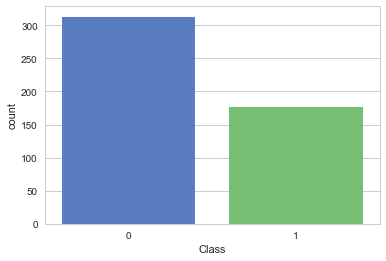

In [76]:
benign, malign = train_y.value_counts()
print("Benign samples: {}.".format(benign))
print("Malign samples: {}.".format(malign))
sns.countplot(train_y,label="Count")

__Observations:__

We can observe that the classification problem is imbalanced. In other words, __malign__ samples are less common than __benign__ samples, it will be important to measure other metrics like F1-measure besides accuracy for comparing the results.

# 3.  Feature selection 

In [77]:
train.describe()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,4.474438,3.186094,3.235174,2.901840,3.222904,3.545112,3.525562,2.934560,1.678937
std,2.899240,3.083558,2.985606,2.953634,2.215215,3.608423,2.495049,3.102718,1.813312
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


__Observations:__

Note that the __minimum__ value across all features is 1 and that the __maximum__ is 10.

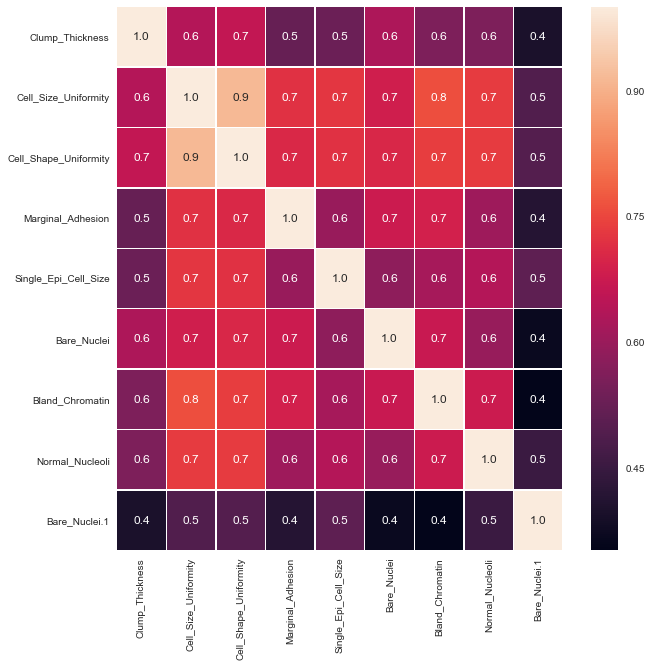

In [78]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

__Observations:__

The __Cell_Size_Uniformity__ is highly correlated with __Cell_Shape_Uniformity__ and with __Bland_Chromatin__.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

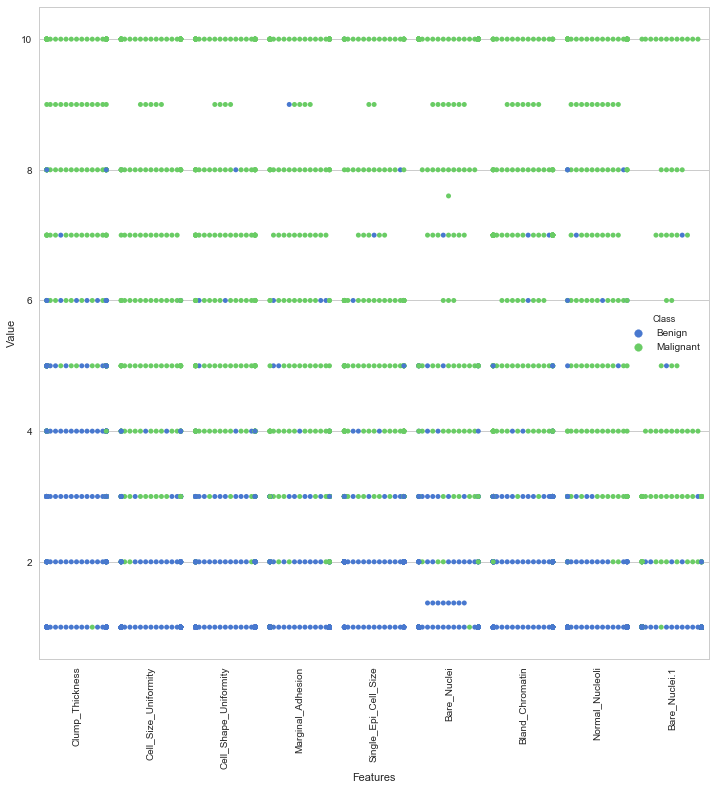

In [79]:
sns.set(style="whitegrid", palette="muted")
data = pd.concat([train_y.map({1:'Malignant',0:'Benign'}),train],axis=1)
data = pd.melt(data,id_vars="Class",
                    var_name="Features",
                    value_name='Value')
plt.figure(figsize=(12,12))
sns.swarmplot(x="Features", y="Value", hue="Class", data=data)

plt.xticks(rotation=90)

__Observations:__

All features across the Swarn plot are clear in terms of separating the classes with their values. __Higher__ values of __each__ feature tend to correspond to __malignant cells__ whereas __lower__ values tend to correspond to __benign cells__. 

__1) Clump_Thickness__

Malignant for values belonging to __[7,10]__.

Benign for values belonging to __[1,4]__.


__2) Cell_Size_Uniformity__
 
Malignant for values belonging to __[3,10]__.

Benign for values belonging to __[1,2]__.


__3) Cell_Shape_Uniformity__
 
Malignant for values belonging to __[4,10]__.

Benign for values belonging to __[1,3]__.


__4) Marginal Adhesion__
 
Malignant for values belonging to __[4,10]__.

Benign for values belonging to __[1,3]__.


__5) Single Epi Cell Size__
 
Malignant for values belonging to __[7,10]__.

Benign for values belonging to __[1,4]__.


__6) Bare Nuclei__

Malignant for values belonging to __[4,10]__.

Benign for values belonging to __[1,2]__.


__7) Bland Chromatin__

Malignant for values belonging to __[4,10]__.

Benign for values belonging to __[1,3]__.


__8) Normal Nucleoli__
 
Malignant for values belonging to __[4,10]__.

Benign for values belonging to __[1,2]__.


__9) Mitoses__
 
Malignant for values belonging to __[2,10]__.

Benign for values belonging to __[1]__.

__Note:__ The intervals not refered for each feature are a __mix of both malignant and benign samples without a clear seperation__.

Not only the feature __Cell_Size_Uniformity__ is highly correlated with __Cell_Shape_Uniformity__ and __Bland_Chromatin__, but also the seperation intervals are rather similar. Thus, we will drop __Cell_Shape_Uniformity__ and __Bland_Chromatin__.

In [80]:
train = train.drop(['Cell_Shape_Uniformity','Bland_Chromatin'], axis=1)
test = test.drop(['Cell_Shape_Uniformity','Bland_Chromatin'], axis=1)

# 4. Classification using Feature Selection

In [81]:
def updateBest(best_score, best_hyp, *args):
    for tupple in args:
        best_hyp[tupple[0]] = tupple[1]
    
    print("New best set of values:")
    print(best_hyp)
    print("Mean accuracy = "+str(round(best_score,6))+" (with 5-fold cross validation).")
    
    return best_score, best_hyp

## 4.1. Support Vector Machine

In [82]:
def SVM_GridSearch(train, train_y, kernel, gamma, C):
    best_score = 0
    best_values_SVM = {}
    start = time.time()
    
    for i in range(len(kernel)):
        for j in range(len(gamma)):
            for k in range(len(C)):
                hyp1 = kernel[i]
                hyp2 = gamma[j]
                hyp3 = C[k]
                
                clf = svm.SVC(kernel=hyp1, gamma=hyp2, C=hyp3, degree=1)
                score = cross_val_score(clf, train, train_y, cv=5).mean()
                
                if score > best_score:
                    best_score, best_values_SVM = updateBest(score, best_values_SVM,
                                                             ('kernel', hyp1), ('gamma', hyp2), ('C', hyp3))
                    partial = time.time()
                    print(" found after " + str(round(partial - start,2)) + " seconds\n")

    end = time.time()
    
    optimal_SVM = svm.SVC(kernel=best_values_SVM['kernel'], gamma=best_values_SVM['gamma'], 
                  C=best_values_SVM['C'], degree=1)
    
    best_score = round(best_score, 6)
    print("The best values are:")
    print(best_values_SVM)
    print("Best accuracy = " + str(best_score)+" (with 5-fold cross validation)")
    print(" found in " + str(round(end - start,2)) + " seconds")
    
    return optimal_SVM, best_score

In [83]:
kernel = ['rbf','poly'] # different kernels
gamma = [0.1, 1, 10] # gamma coefficient for RBF and polynomial (higher values tend to overfit data)
C = [0.1, 1, 10, 100] # different penalties of the error term

clf_SVM, best_score = SVM_GridSearch(train, train_y, kernel, gamma, C)

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
Mean accuracy = 0.9632 (with 5-fold cross validation).
 found after 0.03 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Mean accuracy = 0.973426 (with 5-fold cross validation).
 found after 0.06 seconds

New best set of values:
{'kernel': 'poly', 'gamma': 0.1, 'C': 1}
Mean accuracy = 0.977529 (with 5-fold cross validation).
 found after 0.61 seconds

The best values are:
{'kernel': 'poly', 'gamma': 0.1, 'C': 1}
Best accuracy = 0.977529 (with 5-fold cross validation)
 found in 7.08 seconds


In [84]:
svm_ac = best_score
print("SVM mean accuracy in cross-validation: {:.3%}".format(svm_ac))

SVM mean accuracy in cross-validation: 97.753%


## 4.2. Random forest

In [85]:
def RandomForest_RandomSearch(train, train_y, min_samples_leaf_values, min_samples_split_values, 
                              max_depth_values, n_estimators_values, iterations=200):
    best_score = 0
    best_values_RF = {}
    start = time.time()
    
    for i in range(1,iterations):
        hyp1 = np.random.choice(a=min_samples_leaf_values)
        hyp2 = np.random.choice(a=min_samples_split_values)
        hyp3 = np.random.choice(a=max_depth_values)
        hyp4 = np.random.choice(a=n_estimators_values)

        clf = RandomForestClassifier(random_state=10, min_samples_leaf=hyp1, min_samples_split=hyp2, 
                                                    max_depth=hyp3, n_estimators=hyp4).fit(train, train_y)
        
        score = cross_val_score(clf, train, train_y, cv=5).mean()

        if score > best_score:
            best_score, best_values_RF = updateBest(score, best_values_RF,
                                                    ('min_sample_leaf', hyp1), ('min_sample_split', hyp2), 
                                                    ('max_depth', hyp3), ('n_estimators', hyp4))
            partial = time.time()
            print(" found after " + str(round(partial - start,2)) + " seconds\n")

    end = time.time()

    optimal_RF = RandomForestClassifier(random_state=10, min_samples_leaf=best_values_RF['min_sample_leaf'], min_samples_split=best_values_RF['min_sample_split'], 
                                                    max_depth=best_values_RF['max_depth'], n_estimators=best_values_RF['n_estimators']).fit(train, train_y)
    best_score = round(best_score, 6)
    print("The best values are:")
    print(best_values_RF)
    print("Best mean accuracy = " + str(best_score) +" (with 5-fold cross validation).")
    print(" found in " + str(round(end - start,2)) + " seconds.")
    
    return optimal_RF, best_score

In [86]:
min_samples_leaf_values = np.arange(1, 20, 1)
min_samples_split_values = np.arange(2, 50, 1)
max_depth_values = np.arange(1, 100, 1)
n_estimators_values = np.arange(80,200,1)

clf_RF, best_score = RandomForest_RandomSearch(train, train_y, min_samples_leaf_values, min_samples_split_values, 
                                                max_depth_values, n_estimators_values)

New best set of values:
{'min_sample_leaf': 14, 'min_sample_split': 28, 'max_depth': 1, 'n_estimators': 86}
Mean accuracy = 0.961118 (with 5-fold cross validation).
 found after 1.34 seconds

New best set of values:
{'min_sample_leaf': 16, 'min_sample_split': 30, 'max_depth': 94, 'n_estimators': 197}
Mean accuracy = 0.973405 (with 5-fold cross validation).
 found after 4.23 seconds

New best set of values:
{'min_sample_leaf': 7, 'min_sample_split': 6, 'max_depth': 19, 'n_estimators': 150}
Mean accuracy = 0.977508 (with 5-fold cross validation).
 found after 8.08 seconds

New best set of values:
{'min_sample_leaf': 3, 'min_sample_split': 17, 'max_depth': 39, 'n_estimators': 139}
Mean accuracy = 0.979528 (with 5-fold cross validation).
 found after 28.1 seconds

New best set of values:
{'min_sample_leaf': 7, 'min_sample_split': 10, 'max_depth': 97, 'n_estimators': 98}
Mean accuracy = 0.97957 (with 5-fold cross validation).
 found after 58.88 seconds

The best values are:
{'min_sample_lea

In [87]:
rf_ac = best_score
print("Random Forest mean accuracy in cross-validation: {:.3%}".format(rf_ac))

Random Forest mean accuracy in cross-validation: 97.957%


## 4.3. KNearest Neighbors

In [88]:
def KNN_RandomSearch(train, train_y, K, algorithm, leaf_size, distances, iterations=200):
    best_score = 0
    best_values_KNN = {}
    start = time.time()

    for i in range(1, iterations):
        hyp1 = np.random.choice(a=K)
        hyp2 = np.random.choice(a=algorithm)
        hyp3 = np.random.choice(a=leaf_size)
        hyp4 = np.random.choice(a=distances)

        clf = KNeighborsClassifier(n_neighbors=hyp1, algorithm=hyp2, 
                                   leaf_size=hyp3, p=hyp4)
        score = cross_val_score(clf, train, train_y, cv=5).mean()

        if score > best_score:
            best_score, best_values_KNN = updateBest(score, best_values_KNN,
                                                    ('K', hyp1), ('algorithm', hyp2), 
                                                    ('leaf size', hyp3), ('distance metric', hyp4))
            partial = time.time()
            print(" found after " + str(round(partial - start,2)) + " seconds\n")

    end = time.time()

    optimal_KNN = KNeighborsClassifier(n_neighbors=best_values_KNN['K'], algorithm=best_values_KNN['algorithm'], 
                                  leaf_size=best_values_KNN['leaf size'], p=best_values_KNN['distance metric'])
    
    best_score = round(best_score,6)
    print("The best values are:")
    print(best_values_KNN)
    print("Best accuracy = " + str(best_score)+" (with 5-fold cross validation).")
    print(" found in " + str(round(end - start,2)) + " seconds")
    
    return optimal_KNN, best_score

In [89]:
K = [7, 9, 11, 13, 15, 17, 19, 21]
algorithm = ['ball_tree','kd_tree']
leaf_size = np.arange(20, 70, 1)
distances = [1, 2]

clf_KNN, best_score = KNN_RandomSearch(train, train_y, K, algorithm, leaf_size, distances)

New best set of values:
{'K': 17, 'algorithm': 'ball_tree', 'leaf size': 45, 'distance metric': 1}
Mean accuracy = 0.963138 (with 5-fold cross validation).
 found after 0.02 seconds

New best set of values:
{'K': 7, 'algorithm': 'ball_tree', 'leaf size': 33, 'distance metric': 2}
Mean accuracy = 0.975488 (with 5-fold cross validation).
 found after 0.05 seconds

New best set of values:
{'K': 11, 'algorithm': 'ball_tree', 'leaf size': 33, 'distance metric': 2}
Mean accuracy = 0.977508 (with 5-fold cross validation).
 found after 0.29 seconds

The best values are:
{'K': 11, 'algorithm': 'ball_tree', 'leaf size': 33, 'distance metric': 2}
Best accuracy = 0.977508 (with 5-fold cross validation).
 found in 4.26 seconds


In [90]:
knn_ac = best_score
print("KNN mean accuracy in cross-validation: {:.3%}".format(knn_ac))

KNN mean accuracy in cross-validation: 97.751%


## 4.4. Feature selection results 

In [93]:
def getResults(fitted_classifier, features, true_labels):
    prediction = fitted_classifier.predict(features)
    cm = confusion_matrix(true_labels, prediction)
    df_cm = pd.DataFrame(cm, index = ["True class: Benign","True class: Malign"],
                         columns = ["Predicted class: Benign","Predicted class: Malign"])
    plt.figure(figsize = (8,6))
    sns.set(font_scale=1.1)
    sns.heatmap(df_cm, annot=True, fmt="d")
    
    ac = round(accuracy_score(true_labels, prediction), 3)
    
    # F1_score
    f1score = round(f1_score(true_labels, prediction), 3)
    recall_1 = (cm[1][1])/(cm[1][1]+cm[1][0])
    recall_0 = (cm[0][0])/(cm[0][0]+cm[0][1])
    precision_1 = (cm[1][1])/(cm[1][1]+cm[0][1])
    precision_0 = (cm[0][0])/(cm[0][0]+cm[1][0])
    
    return ac, f1score, recall_1, recall_0, precision_1, precision_0

def Sort(sub_li): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of the sublist
    return(sorted(sub_li, key = lambda x: x[2], reverse=True)) 

def choose_best(acc_svm, clf_SVM, acc_rf, clf_RF, acc_knn, clf_KNN):
    scores = [['SVM', clf_SVM, acc_svm],['Random Forest', clf_RF, acc_rf],['KNN', clf_KNN, acc_knn]]
    sorted_scores = Sort(scores)
    best_classifier = sorted_scores[0]
    
    if best_classifier[2] == sorted_scores[1][2]:
        print("There is a tie in Accuracy between {} and {} classifiers.".format(best_classifier[0],
                                                                                   sorted_scores[1][0]))
        print("{} classifier was chosen\n".format(best_classifier[0]))
        
    elif best_classifier[2] == sorted_scores[1][2] and sorted_scores[1][2] == sorted_scores[2][2]:
        print("There is a tie in Accuracy between {}, {} and {} classifiers.".format(best_classifier[0],
                                                                                       sorted_scores[1][0],
                                                                                       sorted_scores[2][0]))
        print("{} classifier was chosen\n".format(best_classifier[0]))
    else:
        pass
    return best_classifier

The best classifier is Random Forest with Accuracy = 97.96% in 5-fold cross validation.

Accuracy in test set with Random Forest classifier: 0.957

F1-score in test set with Random Forest classifier: 0.934



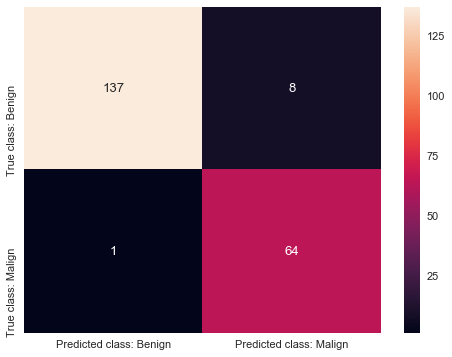

In [94]:
best_classifier_FS = choose_best(svm_ac, clf_SVM, rf_ac, clf_RF, knn_ac, clf_KNN)
print("The best classifier is {} with Accuracy = {:.2%} in 5-fold cross validation.\n".format(best_classifier_FS[0],
                                                                best_classifier_FS[2]))

fitted_clf_FS = best_classifier_FS[1].fit(train,train_y)
ac_FS, f1_FS, r1_FS, r0_FS, p1_FS, p0_FS = getResults(fitted_clf_FS, test, test_y)
print("Accuracy in test set with {} classifier: {}\n".format(best_classifier_FS[0], ac_FS))
print("F1-score in test set with {} classifier: {}\n".format(best_classifier_FS[0], f1_FS))

The classifier __Random Forest__ was the one that the best results regarding the mean accuracy in the validations sets of the 5-fold cross validation. Thus, we choose it to apply to the test set. 

__Results:__

__Accuracy__ in __test__ set with __Random Forest__ classifier: __95.7%__.

__F1-score__ in __test__ set with __Random Forest__ classifier: __93.4%__.

# 5. Apply PCA instead of Feature Selection

In [95]:
def get_N_PC(N, train, test):
    pca = PCA(n_components=N)
    principalComponents = pca.fit_transform(train)
    
    train = pd.DataFrame(data=principalComponents, columns=["PC"+str(i) for i in range(1, N+1)])
    principalComponents = pca.fit_transform(test)
    
    test = pd.DataFrame(data=principalComponents, columns=["PC"+str(i) for i in range(1, N+1)])
    return train, test

## 5.1. Split dataset into train a test set

In [96]:
train, test = train_test_split(dataset, test_size=0.3, random_state=10)
train_y = train.Class
test_y = test.Class
print("Train size: {} samples.".format(len(train)))
print("Test size: {} samples.".format(len(test)))
train = train.drop(['Class'],axis = 1)
test = test.drop(['Class'],axis = 1)

Train size: 489 samples.
Test size: 210 samples.


## 5.2. Normalize data

In [97]:
train = (train-train.mean())/train.max()-train.min()
test = (test-test.mean())/test.max()-test.min()

## 5.3. Explained variance of PCA

# of Principal Components: 1 
Total variance explained: 69.5

# of Principal Components: 2 
Total variance explained: 76.7

# of Principal Components: 3 
Total variance explained: 82.5

# of Principal Components: 4 
Total variance explained: 86.9

# of Principal Components: 5 
Total variance explained: 90.6

# of Principal Components: 6 
Total variance explained: 94.2



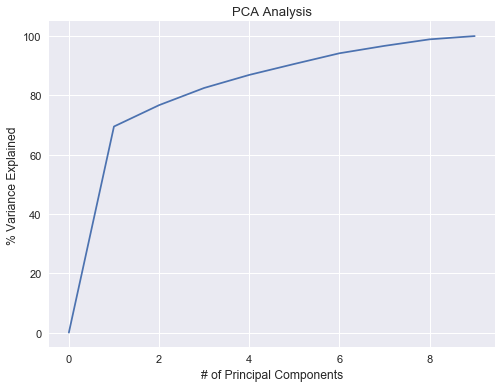

In [98]:
pca = PCA()
pca.fit(train)
explained_var = pca.explained_variance_ratio_ # calculate variance ratios
pcas_vars = np.cumsum(np.round(explained_var, decimals=3)*100)
pcas_vars = np.insert(pcas_vars, 0, 0) # insert a 0 in first position for plotting

plt.figure(1, figsize=(8, 6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Principal Components')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(pcas_vars)

for i in range(1, len(pcas_vars)):
    if pcas_vars[i] >= 95:
        break
    print("# of Principal Components: {} \nTotal variance explained: {}\n".format(i, round(pcas_vars[i], 1)))

# 6. Classification using the first 3 Principal Components (82.5% variance explained)

In [99]:
train_3PC, test_3PC = get_N_PC(3, train, test)
train_3PC.head()

,PC1,PC2,PC3
0,-0.638253,0.057713,-0.121004
1,-0.482277,-0.021178,0.049254
2,-0.547260,0.012091,0.020767
3,-0.477699,0.007318,0.107008
4,0.209445,0.026724,0.554528


## 6.1. Support Vector Machine

In [100]:
kernel = ['rbf','poly'] # different kernels
gamma = [0.1, 1, 10] # gamma coefficient for RBF and polynomial (higher values tend to overfit data)
C = [0.1, 1, 10, 100] # different penalties of the error term

clf_SVM, best_score = SVM_GridSearch(train_3PC, train_y, kernel, gamma, C)

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
Mean accuracy = 0.959118 (with 5-fold cross validation).
 found after 0.02 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Mean accuracy = 0.971406 (with 5-fold cross validation).
 found after 0.04 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
Mean accuracy = 0.977508 (with 5-fold cross validation).
 found after 0.06 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 1, 'C': 0.1}
Mean accuracy = 0.977529 (with 5-fold cross validation).
 found after 0.1 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 1, 'C': 1}
Mean accuracy = 0.97957 (with 5-fold cross validation).
 found after 0.11 seconds

The best values are:
{'kernel': 'rbf', 'gamma': 1, 'C': 1}
Best accuracy = 0.97957 (with 5-fold cross validation)
 found in 0.44 seconds


In [101]:
svm_ac = best_score
print("SVM mean accuracy in cross-validation: {:.3%}".format(svm_ac))

SVM mean accuracy in cross-validation: 97.957%


## 6.2. Random Forest

In [102]:
min_samples_leaf_values = np.arange(1, 20, 1)
min_samples_split_values = np.arange(2, 50, 1)
max_depth_values = np.arange(1, 100, 1)
n_estimators_values = np.arange(80,200,1)

clf_RF, best_score = RandomForest_RandomSearch(train_3PC, train_y, min_samples_leaf_values, min_samples_split_values, 
                                                max_depth_values, n_estimators_values)

New best set of values:
{'min_sample_leaf': 9, 'min_sample_split': 19, 'max_depth': 61, 'n_estimators': 113}
Mean accuracy = 0.975488 (with 5-fold cross validation).
 found after 1.26 seconds

New best set of values:
{'min_sample_leaf': 13, 'min_sample_split': 35, 'max_depth': 44, 'n_estimators': 169}
Mean accuracy = 0.977529 (with 5-fold cross validation).
 found after 3.14 seconds

The best values are:
{'min_sample_leaf': 13, 'min_sample_split': 35, 'max_depth': 44, 'n_estimators': 169}
Best mean accuracy = 0.977529 (with 5-fold cross validation).
 found in 345.45 seconds.


In [103]:
rf_ac = best_score
print("Random Forest mean accuracy in cross-validation: {:.3%}".format(rf_ac))

Random Forest mean accuracy in cross-validation: 97.753%


## 6.3. KNearest Neighbors

In [104]:
K = [7, 9, 11, 13, 15, 17, 19, 21]
algorithm = ['ball_tree','kd_tree']
leaf_size = np.arange(20, 70, 1)
distances = [1, 2]

clf_KNN, best_score = KNN_RandomSearch(train_3PC, train_y, K, algorithm, leaf_size, distances)

New best set of values:
{'K': 11, 'algorithm': 'kd_tree', 'leaf size': 34, 'distance metric': 2}
Mean accuracy = 0.97957 (with 5-fold cross validation).
 found after 0.02 seconds

The best values are:
{'K': 11, 'algorithm': 'kd_tree', 'leaf size': 34, 'distance metric': 2}
Best accuracy = 0.97957 (with 5-fold cross validation).
 found in 3.47 seconds


In [105]:
knn_ac = best_score
print("KNN mean accuracy in cross-validation: {:.3%}".format(knn_ac))

KNN mean accuracy in cross-validation: 97.957%


## 6.4. First 3 Principal Components results

There is a tie in Accuracy between SVM and KNN classifiers.
SVM classifier was chosen

The best classifier is SVM with Accuracy = 97.96% in 5-fold cross validation.

Accuracy in test set with SVM classifier: 0.952

F1-score in test set with SVM classifier: 0.928



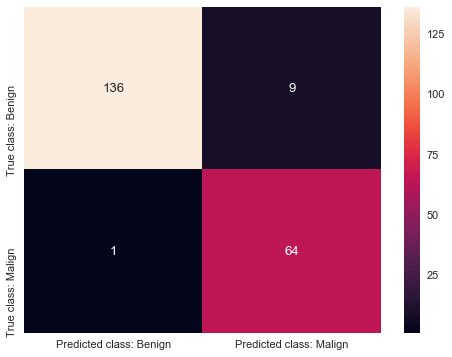

In [106]:
best_classifier_3PC = choose_best(svm_ac, clf_SVM, rf_ac, clf_RF, knn_ac, clf_KNN)
print("The best classifier is {} with Accuracy = {:.2%} in 5-fold cross validation.\n".format(best_classifier_3PC[0],
                                                                best_classifier_3PC[2]))

fitted_clf_3PC = best_classifier_3PC[1].fit(train_3PC,train_y)
ac_3PC, f1_3PC, r1_3PC, r0_3PC, p1_3PC, p0_3PC = getResults(fitted_clf_3PC, test_3PC, test_y)
print("Accuracy in test set with {} classifier: {}\n".format(best_classifier_3PC[0], ac_3PC))
print("F1-score in test set with {} classifier: {}\n".format(best_classifier_3PC[0], f1_3PC))

The classifier __SVM__ was the one that the best results regarding the mean accuracy in the validations sets of the 5-fold cross validation. Thus, we choose it to apply to the test set. 

__Results:__

__Accuracy__ in __test__ set with __SVM__ classifier: __95.2%__.

__F1-score__ in __test__ set with __SVM__ classifier: __92.8%__.

# 7. Classification using the first 5 Principal Components (90.6% variance explained)

In [107]:
train_5PC, test_5PC = get_N_PC(5, train, test)
train_5PC.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.638253,0.057713,-0.121004,-0.027099,0.091669
1,-0.482277,-0.021178,0.049254,0.067760,-0.092105
2,-0.547260,0.012091,0.020767,0.006378,-0.010393
3,-0.477699,0.007318,0.107008,0.045779,-0.028195
4,0.209445,0.026724,0.554528,0.362692,0.207058


## 7.1. Support Vector Machine

In [108]:
kernel = ['rbf','poly'] # different kernels
gamma = [0.1, 1, 10] # gamma coefficient for RBF and polynomial (higher values tend to overfit data)
C = [0.1, 1, 10, 100] # different penalties of the error term

clf_SVM, best_score = SVM_GridSearch(train_5PC, train_y, kernel, gamma, C)

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
Mean accuracy = 0.961159 (with 5-fold cross validation).
 found after 0.05 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Mean accuracy = 0.971406 (with 5-fold cross validation).
 found after 0.08 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
Mean accuracy = 0.97957 (with 5-fold cross validation).
 found after 0.12 seconds

The best values are:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
Best accuracy = 0.97957 (with 5-fold cross validation)
 found in 0.56 seconds


In [109]:
svm_ac = best_score
print("SVM mean accuracy in cross-validation: {:.3%}".format(svm_ac))

SVM mean accuracy in cross-validation: 97.957%


## 7.2. Random Forest

In [110]:
min_samples_leaf_values = np.arange(1, 20, 1)
min_samples_split_values = np.arange(2, 50, 1)
max_depth_values = np.arange(1, 100, 1)
n_estimators_values = np.arange(80,200,1)

clf_RF, best_score = RandomForest_RandomSearch(train_5PC, train_y, min_samples_leaf_values, min_samples_split_values, 
                                                max_depth_values, n_estimators_values)

New best set of values:
{'min_sample_leaf': 13, 'min_sample_split': 17, 'max_depth': 96, 'n_estimators': 142}
Mean accuracy = 0.979591 (with 5-fold cross validation).
 found after 1.73 seconds

The best values are:
{'min_sample_leaf': 13, 'min_sample_split': 17, 'max_depth': 96, 'n_estimators': 142}
Best mean accuracy = 0.979591 (with 5-fold cross validation).
 found in 363.19 seconds.


In [111]:
rf_ac = best_score
print("Random Forest mean accuracy in cross-validation: {:.3%}".format(rf_ac))

Random Forest mean accuracy in cross-validation: 97.959%


## 7.3. KNearest Neighbors

In [112]:
K = [7, 9, 11, 13, 15, 17, 19, 21]
algorithm = ['ball_tree','kd_tree']
leaf_size = np.arange(20, 70, 1)
distances = [1, 2]

clf_KNN, best_score = KNN_RandomSearch(train_5PC, train_y, K, algorithm, leaf_size, distances)

New best set of values:
{'K': 9, 'algorithm': 'kd_tree', 'leaf size': 62, 'distance metric': 1}
Mean accuracy = 0.977508 (with 5-fold cross validation).
 found after 0.02 seconds

New best set of values:
{'K': 15, 'algorithm': 'kd_tree', 'leaf size': 41, 'distance metric': 2}
Mean accuracy = 0.977529 (with 5-fold cross validation).
 found after 0.05 seconds

The best values are:
{'K': 15, 'algorithm': 'kd_tree', 'leaf size': 41, 'distance metric': 2}
Best accuracy = 0.977529 (with 5-fold cross validation).
 found in 3.42 seconds


In [113]:
knn_ac = best_score
print("KNN mean accuracy in cross-validation: {:.3%}".format(knn_ac))

KNN mean accuracy in cross-validation: 97.753%


## 7.4. First 5 Principal components results

The best classifier is Random Forest with Accuracy = 97.96% in 5-fold cross validation.

Accuracy in test set with Random Forest classifier: 0.943

F1-score in test set with Random Forest classifier: 0.914



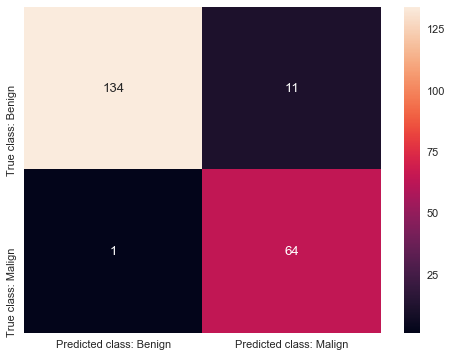

In [114]:
best_classifier_5PC = choose_best(svm_ac, clf_SVM, rf_ac, clf_RF, knn_ac, clf_KNN)
print("The best classifier is {} with Accuracy = {:.2%} in 5-fold cross validation.\n".format(best_classifier_5PC[0],
                                                                best_classifier_5PC[2]))

fitted_clf_5PC = best_classifier_5PC[1].fit(train_5PC,train_y)
ac_5PC, f1_5PC, r1_5PC, r0_5PC, p1_5PC, p0_5PC = getResults(fitted_clf_5PC, test_5PC, test_y)
print("Accuracy in test set with {} classifier: {}\n".format(best_classifier_5PC[0], ac_5PC))
print("F1-score in test set with {} classifier: {}\n".format(best_classifier_5PC[0], f1_5PC))

The classifiers had the same results regarding the mean accuracy in the validations sets of the 5-fold cross validation. Thus, we choose one of it to apply to the test set. 

__Results:__

__Accuracy__ in __test__ set with __Random Forest__ classifier: __94.3%__.

__F1-score__ in __test__ set with __Random Forest__ classifier: __91.4%__.

# 8. Classification without a dimensionality reduction method 

In [115]:
train_no_DR, test_no_DR = train_test_split(dataset, test_size=0.3, random_state=10)
train_y = train_no_DR.Class
test_y = test_no_DR.Class
print("Train size: {} samples.".format(len(train)))
print("Test size: {} samples.".format(len(test)))
train_no_DR = train_no_DR.drop(['Class'],axis = 1)
test_no_DR = test_no_DR.drop(['Class'],axis = 1)

Train size: 489 samples.
Test size: 210 samples.


## 8.1. Support Vector Machine

In [116]:
kernel = ['rbf','poly'] # different kernels
gamma = [0.1, 1, 10] # gamma coefficient for RBF and polynomial (higher values tend to overfit data)
C = [0.1, 1, 10, 100] # different penalties of the error term

clf_SVM, best_score = SVM_GridSearch(train_no_DR, train_y, kernel, gamma, C)

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
Mean accuracy = 0.94277 (with 5-fold cross validation).
 found after 0.04 seconds

New best set of values:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Mean accuracy = 0.969323 (with 5-fold cross validation).
 found after 0.07 seconds

New best set of values:
{'kernel': 'poly', 'gamma': 0.1, 'C': 0.1}
Mean accuracy = 0.977508 (with 5-fold cross validation).
 found after 0.61 seconds

The best values are:
{'kernel': 'poly', 'gamma': 0.1, 'C': 0.1}
Best accuracy = 0.977508 (with 5-fold cross validation)
 found in 5.88 seconds


In [117]:
svm_ac = best_score
print("SVM mean accuracy in cross-validation: {:.3%}".format(svm_ac))

SVM mean accuracy in cross-validation: 97.751%


## 8.2. Random Forest

In [118]:
min_samples_leaf_values = np.arange(1, 20, 1)
min_samples_split_values = np.arange(2, 50, 1)
max_depth_values = np.arange(1, 100, 1)
n_estimators_values = np.arange(80,200,1)

clf_RF, best_score = RandomForest_RandomSearch(train_no_DR, train_y, min_samples_leaf_values, min_samples_split_values, 
                                                max_depth_values, n_estimators_values)

New best set of values:
{'min_sample_leaf': 3, 'min_sample_split': 37, 'max_depth': 55, 'n_estimators': 148}
Mean accuracy = 0.971385 (with 5-fold cross validation).
 found after 1.79 seconds

New best set of values:
{'min_sample_leaf': 6, 'min_sample_split': 31, 'max_depth': 28, 'n_estimators': 97}
Mean accuracy = 0.975467 (with 5-fold cross validation).
 found after 2.97 seconds

The best values are:
{'min_sample_leaf': 6, 'min_sample_split': 31, 'max_depth': 28, 'n_estimators': 97}
Best mean accuracy = 0.975467 (with 5-fold cross validation).
 found in 345.79 seconds.


In [119]:
rf_ac = best_score
print("Random Forest mean accuracy in cross-validation: {:.3%}".format(rf_ac))

Random Forest mean accuracy in cross-validation: 97.547%


## 8.3. KNearest Neighbors

In [120]:
K = [7, 9, 11, 13, 15, 17, 19, 21]
algorithm = ['ball_tree','kd_tree']
leaf_size = np.arange(20, 70, 1)
distances = [1, 2]

clf_KNN, best_score = KNN_RandomSearch(train_no_DR, train_y, K, algorithm, leaf_size, distances)

New best set of values:
{'K': 19, 'algorithm': 'ball_tree', 'leaf size': 44, 'distance metric': 1}
Mean accuracy = 0.961118 (with 5-fold cross validation).
 found after 0.02 seconds

New best set of values:
{'K': 13, 'algorithm': 'ball_tree', 'leaf size': 42, 'distance metric': 1}
Mean accuracy = 0.965241 (with 5-fold cross validation).
 found after 0.05 seconds

New best set of values:
{'K': 7, 'algorithm': 'kd_tree', 'leaf size': 33, 'distance metric': 2}
Mean accuracy = 0.973405 (with 5-fold cross validation).
 found after 0.08 seconds

New best set of values:
{'K': 13, 'algorithm': 'ball_tree', 'leaf size': 21, 'distance metric': 2}
Mean accuracy = 0.975467 (with 5-fold cross validation).
 found after 0.25 seconds

The best values are:
{'K': 13, 'algorithm': 'ball_tree', 'leaf size': 21, 'distance metric': 2}
Best accuracy = 0.975467 (with 5-fold cross validation).
 found in 3.89 seconds


In [121]:
knn_ac = best_score
print("KNN mean accuracy in cross-validation: {:.3%}".format(knn_ac))

KNN mean accuracy in cross-validation: 97.547%


## 8.4. Without a dimensionality reduction method results

The best classifier is SVM with Accuracy = 97.75% in 5-fold cross validation.

Accuracy in test set with SVM classifier: 0.952

F1-score in test set with SVM classifier: 0.926



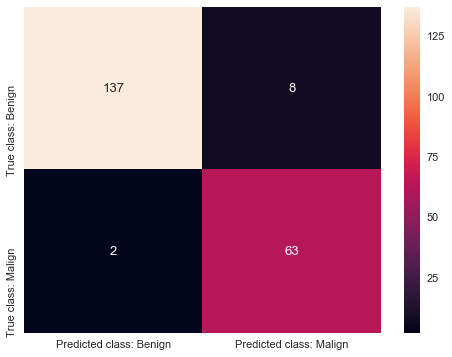

In [122]:
best_classifier_no_DR = choose_best(svm_ac, clf_SVM, rf_ac, clf_RF, knn_ac, clf_KNN)
print("The best classifier is {} with Accuracy = {:.2%} in 5-fold cross validation.\n".format(best_classifier_no_DR[0],
                                                                best_classifier_no_DR[2]))

fitted_clf_no_DR = best_classifier_no_DR[1].fit(train_no_DR,train_y)
ac_no_DR, f1_no_DR, r1_no_DR, r0_no_DR, p1_no_DR, p0_no_DR = getResults(fitted_clf_no_DR, test_no_DR, test_y)
print("Accuracy in test set with {} classifier: {}\n".format(best_classifier_no_DR[0], ac_no_DR))
print("F1-score in test set with {} classifier: {}\n".format(best_classifier_no_DR[0], f1_no_DR))

The classifiers had the same results regarding the mean accuracy in the validations sets of the 5-fold cross validation. Thus, we choose one of it to apply to the test set. 

__Results:__

__Accuracy__ in __test__ set with __SVM__ classifier: __95.2%__.

__F1-score__ in __test__ set with __SVM__ classifier: __92.6%__.

# 9. Final results

In [125]:
typeoftests = ['Feature Selection', '3 Principal Components', '5 Principal Components', 'Without Dimensionality Reduction']
accuracies = [ac_FS, ac_3PC, ac_5PC, ac_no_DR]
fmeasures = [f1_FS, f1_3PC, f1_5PC, f1_no_DR]
recalls_1 = [r1_FS, r1_3PC, r1_5PC, r1_no_DR]
recalls_0 = [r0_FS, r0_3PC, r0_5PC, r0_no_DR]
precisions_1 = [p1_FS, p1_3PC, p1_5PC, p1_no_DR]
precisions_0 = [p0_FS, p0_3PC, p0_5PC, p0_no_DR]
classifiers =[best_classifier_FS[0], best_classifier_3PC[0], best_classifier_5PC[0], best_classifier_no_DR[0]]

final_results = pd.DataFrame({'Preliminary Analysis methodology': typeoftests, 'Accuracy': accuracies, 
                              'F1-measure': fmeasures, 'Recall(1)': recalls_1, 'Recall(0)': recalls_0,
                              'Precision(1)': precisions_1, 'Precision(0)': precisions_0,
                              'Classification algorithm': classifiers})
final_results

,Preliminary Analysis methodology,Accuracy,F1-measure,Recall(1),Recall(0),Precision(1),Precision(0),Classification algorithm
0,Feature Selection,0.957,0.934,0.984615,0.944828,0.888889,0.992754,Random Forest
1,3 Principal Components,0.952,0.928,0.984615,0.937931,0.876712,0.992701,SVM
2,5 Principal Components,0.943,0.914,0.984615,0.924138,0.853333,0.992593,Random Forest
3,Without Dimensionality Reduction,0.952,0.926,0.969231,0.944828,0.887324,0.985612,SVM
